In [1]:
import torch, numpy as np, random
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [2]:
import scanpy as sc
import numpy as np

ST_full = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_breast_cancer.h5ad')
ST_full.var_names_make_unique()
SC_full = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_sc_data.h5ad')
SC_full.var_names_make_unique()

N_A = 2000
N_B = 2000

# Set a seed for reproducibility
rng = np.random.default_rng(seed=42)

A_idx = rng.choice(ST_full.n_obs, size=N_A, replace=False)
B_idx = rng.choice(SC_full.n_obs, size=N_B, replace=False)

ST = ST_full[A_idx].copy()
SC = SC_full[B_idx].copy()

/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
ST.shape

(2000, 313)

In [4]:
SC.shape

(2000, 29733)

In [5]:
np.unique(ST.obs['cell_type'])

array(['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2',
       'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs',
       'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+',
       'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor',
       'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid',
       'Unlabeled'], dtype=object)

In [6]:
import pandas as pd

# Define mapping from fine-grained ST types to major SC types
mapping = {
    # Lymphoid
    'B_Cells': 'B-cells',
    'CD4+_T_Cells': 'T-cells',
    'CD8+_T_Cells': 'T-cells',
    'Stromal_&_T_Cell_Hybrid': 'T-cells',
    'T_Cell_&_Tumor_Hybrid': 'T-cells',

    # Myeloid
    'Macrophages_1': 'Myeloid',
    'Macrophages_2': 'Myeloid',
    'Mast_Cells': 'Myeloid',
    'IRF7+_DCs': 'Myeloid',
    'LAMP3+_DCs': 'Myeloid',
    'TFR+_DCs': 'Myeloid',

    # Epithelial
    'Invasive_Tumor': 'Cancer Epithelial',
    'Prolif_Invasive_Tumor': 'Cancer Epithelial',
    'DCIS_1': 'Cancer Epithelial',
    'DCIS_2': 'Cancer Epithelial',
    'Myoepi_ACTA2+': 'Normal Epithelial',
    'Myoepi_KRT15+': 'Normal Epithelial',

    # Endothelial
    'Endothelial': 'Endothelial',
    'Perivascular-Like': 'Endothelial',

    # Stromal
    'Stromal': 'CAFs',

    # Unlabeled / others
    'Unlabeled': 'Unlabeled'
}

# Apply mapping
ST.obs['celltype_major'] = ST.obs['cell_type'].map(mapping)

# If any fine types weren't mapped
unmapped = ST.obs.loc[ST.obs['celltype_major'].isna(), 'cell_type'].unique()
if len(unmapped) > 0:
    print("Unmapped cell types:", unmapped)
else:
    print("✅ All cell types mapped successfully!")



✅ All cell types mapped successfully!


In [7]:
# Reorder ST and SC so that common columns are first and in the same order
common_vars = ST.var_names.intersection(SC.var_names)
other_ST = [v for v in ST.var_names if v not in common_vars]
other_SC = [v for v in SC.var_names if v not in common_vars]
# ST = ST[:, list(common_vars) + other_ST]
# SC = SC[:, list(common_vars) + other_SC]
ST = ST[:, list(common_vars) ]
SC = SC[:, list(common_vars) ]


In [8]:
ST.shape,SC.shape

((2000, 308), (2000, 308))

In [9]:
import scmodal

In [10]:
model = scmodal.model.Model(training_steps=10000, device = 'gpu')

In [11]:
model.preprocess(ST,SC, shared_gene_num=len(common_vars),alpha = None, eta = None)

preprocess called with alpha: None and eta: None
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [12]:
import numpy as np
model.train()

Begining time:  Tue Nov 25 15:43:15 2025
step 0, loss_D=0.053221, loss_GAN=-0.046050, loss_AE=359.125519, loss_Geo=-14.648249, loss_LA=2174.932617, loss_MNN=53.552704
step 2000, loss_D=0.610416, loss_GAN=-0.582032, loss_AE=5.906717, loss_Geo=-19.168417, loss_LA=0.194832, loss_MNN=1.541189
step 4000, loss_D=0.719069, loss_GAN=-0.693902, loss_AE=5.162394, loss_Geo=-19.163860, loss_LA=0.147699, loss_MNN=1.639979
step 6000, loss_D=0.650300, loss_GAN=-0.620076, loss_AE=5.093065, loss_Geo=-19.177197, loss_LA=0.137780, loss_MNN=1.717122
step 8000, loss_D=0.776394, loss_GAN=-0.746960, loss_AE=4.295330, loss_Geo=-19.134062, loss_LA=0.098867, loss_MNN=1.629348
Ending time:  Tue Nov 25 15:57:29 2025
Training takes 854.53 seconds


In [13]:
model.eval()

Begining time:  Tue Nov 25 15:57:30 2025
Ending time:  Tue Nov 25 15:57:30 2025
Evaluating takes 0.04 seconds


In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

def impute_cell_types(model, ST, SC, n_neighbors=10):
    emb_A = model.latent[:ST.shape[0], :]
    emb_B = model.latent[ST.shape[0]:, :]

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(emb_B)
    knn_idx = nbrs.kneighbors(emb_A, return_distance=False)

    # Factorize string labels to numeric
    labels = np.array(SC.obs["celltype_major"].values)
    codes, uniques = pd.factorize(labels)
    neighbor_codes = codes[knn_idx]

    # Majority vote using bincount (fast + numeric)
    majority_idx = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, neighbor_codes)
    majority_labels = uniques[majority_idx]

    ST.obs["imputed_cell_type"] = majority_labels
    return ST


In [15]:
ST = impute_cell_types(model, ST, SC, n_neighbors=10)

/tmp/ipykernel_3575065/3903814323.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ST.obs["imputed_cell_type"] = majority_labels


In [16]:
#compute ari between imputed cell types and actual cell types
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['imputed_cell_type'])
ari

0.6457243574001019

In [17]:
from sklearn.metrics import adjusted_rand_score
model = scmodal.model.Model(training_steps=1000, device = 'gpu')
model.preprocess(ST,SC, shared_gene_num=len(common_vars),alpha = None, eta = None)

preprocess called with alpha: None and eta: None
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
n_iter = 10
aris = []
for i in range(n_iter):
    print(f"🔄 Iteration {i+1}/{n_iter}")
    if i == 0:
        model.train(load_ckpt=False)  # Start from scratch
    else:
        model.train(load_ckpt=True)  # Continue from saved weights
    model.eval()

    ST = impute_cell_types(model, ST, SC, n_neighbors=10)

    #keep only first word

    ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['imputed_cell_type'])
    aris.append(ari)
    print(f"Iteration ARI: {ari}")

    # if i > 0 and abs(ari - prev_ari) < 0.005:
    #     print("Converged ✅")
    #     break
    prev_ari = ari


🔄 Iteration 1/10
Begining time:  Tue Nov 25 15:57:30 2025
step 0, loss_D=0.053221, loss_GAN=-0.046050, loss_AE=359.125519, loss_Geo=-14.648249, loss_LA=2174.932617, loss_MNN=53.552704
Ending time:  Tue Nov 25 15:58:50 2025
Training takes 79.69 seconds
Begining time:  Tue Nov 25 15:58:50 2025
Ending time:  Tue Nov 25 15:58:50 2025
Evaluating takes 0.03 seconds
Iteration ARI: 0.672845975702979
🔄 Iteration 2/10
Begining time:  Tue Nov 25 15:58:50 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.618409, loss_GAN=-0.586899, loss_AE=6.732442, loss_Geo=-19.166187, loss_LA=0.276434, loss_MNN=1.846299
Ending time:  Tue Nov 25 16:00:06 2025
Training takes 76.38 seconds
Begining time:  Tue Nov 25 16:00:06 2025
Ending time:  Tue Nov 25 16:00:06 2025
Evaluating takes 0.03 s

In [19]:
aris

[0.672845975702979,
 0.6680740175270892,
 0.6761179463299154,
 0.6535806606107737,
 0.6670992826733696,
 0.6523974804445845,
 0.6765299181701048,
 0.6606847040491861,
 0.6642891872857123,
 0.6512772674006594]

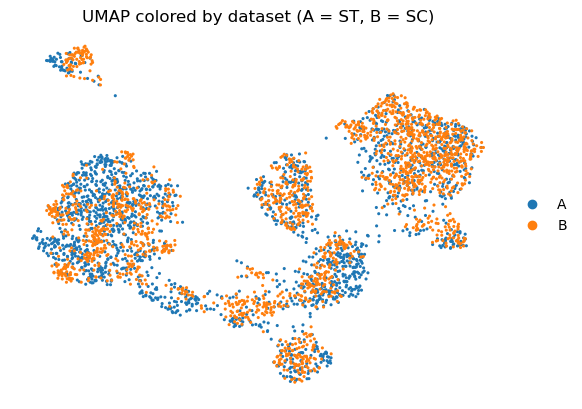

In [20]:
#plot umap of common embedding coloured by modality
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

def plot_umap_AB(model, ST, SC):
    # combined latent
    latent = model.latent

    # create a temporary AnnData to run UMAP
    from anndata import AnnData
    ad = AnnData(latent.copy())

    # assign A/B labels
    nA = ST.shape[0]
    AB_labels = np.array(["A"] * nA + ["B"] * (latent.shape[0] - nA))
    ad.obs["dataset"] = AB_labels

    # compute neighbors + UMAP
    sc.pp.neighbors(ad, use_rep=None, n_neighbors=15, metric="cosine")
    sc.tl.umap(ad)

    # plot
    sc.pl.umap(
        ad,
        color="dataset",
        title="UMAP colored by dataset (A = ST, B = SC)",
        frameon=False,
        size=20
    )
plot_umap_AB(model, ST, SC)

